# 0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier    


warnings.filterwarnings('ignore')

In [2]:
# Load Data
op = 0 # 0: Local, 1: Kaggle

if not op: # Local
    train_path = './data/train.csv'
    test_path = './data/test.csv'
    sub_path = './data/gender_submission.csv'
    save_path = './data/submission.csv'
else:  # Kaggle
    train_path = '/kaggle/input/titanic/train.csv'
    test_path = '/kaggle/input/titanic/test.csv'
    sub_path = '/kaggle/input/titanic/gender_submission.csv'    
    save_path = '/kaggle/working/submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


# 1.

In [3]:
# Remove unnecessary columns
df_train = df_train.drop(columns=['Name', 'Ticket'])
df_test = df_test.drop(columns=['Name', 'Ticket'])

# Check NaN
print(df_train[df_test.columns].isnull().sum())
print("=====================")
print(df_test[df_test.columns].isnull().sum())

PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# NaN list:  Age, Cabin, Fare, Embarked

# Age
def age_to_group(age):
    if pd.isna(age):
        return 7
    elif age <= 10:
        return 0
    elif age <= 20:
        return 1
    elif age <= 30:
        return 2
    elif age <= 40:
        return 3
    elif age <= 50:
        return 4
    elif age <= 60:
        return 5
    else:
        return 6

df_train['AgeGroup'] = df_train['Age'].apply(age_to_group)
df_test['AgeGroup'] = df_test['Age'].apply(age_to_group)

# Fare
df_test['Fare'] = df_test['Fare'].fillna(df_test.groupby('Pclass')['Fare'].transform('mean'))

# Embarked
df_train['Embarked'] = df_train['Embarked'].fillna('N')

# 2. Feature Engineering

In [5]:
# Encoding
encoder = LabelEncoder()

def data_encoding(df):
    df['Sex'] = encoder.fit_transform(df['Sex'])
    df['Embarked'] = encoder.fit_transform(df['Embarked'])
    return df

df_train = data_encoding(df_train)
df_test = data_encoding(df_test)

In [6]:
df_train['FamilySize'] = (df_train['SibSp'] + df_train['Parch']) **2
df_test['FamilySize'] = (df_test['SibSp'] + df_test['Parch']) **2

df_train['IsAlone'] = (df_train['FamilySize'] == 0).astype(int)
df_test['IsAlone'] = (df_test['FamilySize'] == 0).astype(int)

df_train['ClassByFare'] = (df_train['Fare'] / df_train['Pclass'])
df_test['ClassByFare'] = (df_test['Fare'] / df_test['Pclass'])

df_train['SexByEmbarked'] = (df_train['Sex'] + 1) * (df_train['Embarked'] + 1)
df_test['SexByEmbarked'] = (df_test['Sex'] + 1) * (df_test['Embarked'] + 1)

df_train['SexByIsAlone'] = (df_train['Sex'] + 1) * (df_train['IsAlone'] + 1)
df_test['SexByIsAlone'] = (df_test['Sex'] + 1) * (df_test['IsAlone'] + 1)

In [7]:
# Select Feature
feature_cols = ['Pclass', 'Sex', 'FamilySize', 'IsAlone', 'ClassByFare', 'Fare', 'SexByEmbarked', 'SexByIsAlone']
df_train[feature_cols].head(10)

# Check Feature importance
importances = mutual_info_classif(df_train[feature_cols], df_train['Survived'])
for col, imp in zip(feature_cols, importances):
    print(f'{col:<20}: {imp:.4f}')

Pclass              : 0.0413
Sex                 : 0.1318
FamilySize          : 0.0500
IsAlone             : 0.0203
ClassByFare         : 0.1440
Fare                : 0.1272
SexByEmbarked       : 0.1593
SexByIsAlone        : 0.1065


# 3. Model Tuning - XGB

In [8]:
# Split input and target data
X = df_train[feature_cols].to_numpy()
y = df_train['Survived'].to_numpy()
X_pred = df_test[feature_cols].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, randint
# from xgboost import XGBClassifier

# param_dist = {
#     'learning_rate': uniform(0.01, 0.3),
#     'min_child_weight': randint(1, 6),
#     'subsample': uniform(0.7, 0.3),
#     'colsample_bytree': uniform(0.7, 0.3),
# }

# model = XGBClassifier(
#     tree_method='hist',
#     max_depth=5,
#     objective='binary:logistic',
#     eval_metric='logloss',
#     use_label_encoder=False,
#     n_estimators=100,
#     reg_lambda=0.1,
#     colsample_bytree=0.9,
#     learning_rate=0.1,
#     min_child_weight=5,
#     subsample=0.9,
#     n_jobs=-1,
# )

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=200,
#     scoring='roc_auc',
#     cv=3,
#     verbose=1,
# )

# random_search.fit(X, y)
# best_model = random_search.best_estimator_
# print(best_model.score(X_train, y_train))
# print(best_model.score(X_val, y_val))
# print(random_search.best_params_)

best_model = XGBClassifier(
    tree_method='hist',
    max_depth=5,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    reg_lambda=0.1,
    learning_rate=0.1,
    n_jobs=-1,
)
best_model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

['Pclass', 'Sex', 'FamilySize', 'IsAlone', 'ClassByFare', 'Fare', 'SexByEmbarked', 'SexByIsAlone']


<BarContainer object of 8 artists>

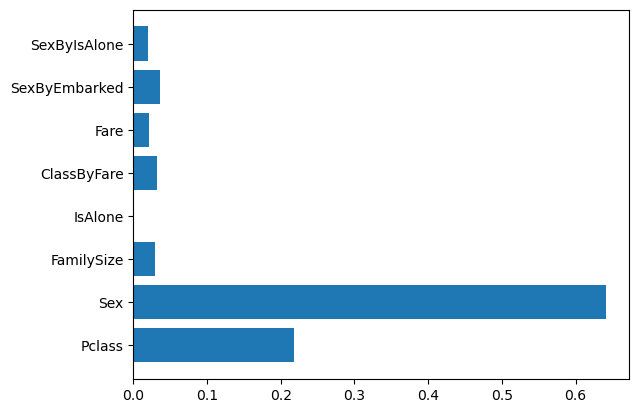

In [15]:
best_model.feature_importances_
print(feature_cols)
plt.barh(feature_cols, best_model.feature_importances_)

# 4. Submission

In [59]:
y_pred = best_model.predict(X_pred)
df_sub['Survived'] = y_pred
df_sub.to_csv(save_path, index=False)